# Predicting Bike Sharing Demand

This project aims to find the most accurate method of predicting bike sharing demand using the Bike Sharing Dataset from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/index.php) ([link to dataset here](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset)). I will be using \_insert methods here\_ going from a simple, basic, "no work" predictor to use as baseline, and work our way up by engineering features, or trying more and more sophisticated predicting methods.

#### A few words about the data:
This data is all about bike sharing demand in the [Capital Bikeshare](https://www.capitalbikeshare.com/) program in Washington, D.C and can prove useful in studying mobility in a city. In short, bike sharing systems operate through a network of kiosk locations all throughout a city generally via memberships. If you live in a major city, chances are you either are familiar with these networks or even using one. For example, in my hometown (Bucharest, Romania) we have at least two private bike sharing services and a few public ones that operate usually within parks. These systems allow people to rent a bike from one docking point and return it to any other docking point, which makes them a viable alternative to public transport or driving, as well as a great way to enjoy a sunny day in the park. As the [UCI dataset](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset) page mentioned, at the time of writing, there were over 500 bike-sharing programs around the world.

#### Business case:  
Rental services are paid, so as a rental service company, one of your concerns is customer satisfaction. Predicting bike rental demand helps adjust supply, especially if it can be done a few days in advance. The big problem with early prediction is that it converges to the task of predicting weather, a task which is notoriously difficult (as outlined, among other sources, by this [article](https://letstalkscience.ca/educational-resources/stem-in-context/why-weather-so-hard-predict), or in [Nate Silver's book "The Signal and the Noise"](https://www.goodreads.com/book/show/13588394-the-signal-and-the-noise?from_search=true&from_srp=true&qid=jxBgJ9qJk1&rank=1)).
That aside, making sure customers have a bike available when they need it ensures they are satisfied with the service and will therefore avoid any bad reviews and maintain reputation.

In [1]:
# std libraries
import os
import tarfile
import urllib
from zipfile import ZipFile

# data processing libraries
import numpy as np
import pandas as pd

# visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Create download variables (url, path to download to)
DOWNLOAD_ROOT = "http://archive.ics.uci.edu/ml/"
DATA_PATH = os.path.join("data")
DATA_URL = DOWNLOAD_ROOT + "machine-learning-databases/00275/Bike-Sharing-Dataset.zip"

In [3]:
def fetch_data(data_url=DATA_URL, data_path=DATA_PATH):
    os.makedirs(data_path, exist_ok=True)
    zip_path = os.path.join(data_path, "Bike-Sharing-Dataset.zip")
    urllib.request.urlretrieve(data_url, zip_path)
    with ZipFile(zip_path, 'r') as data_zip:
        files = data_zip.namelist()
        data_zip.extractall(DATA_PATH) 
        data_zip.close()
    return files

In [4]:
file_names = fetch_data()
print(file_names)

['Readme.txt', 'day.csv', 'hour.csv']


In [5]:
DATA_CSV = os.path.join(DATA_PATH, "hour.csv")

In [6]:
df = pd.read_csv(DATA_CSV)
print("No. of observations:", df.shape[0])
print("No. of columns:", df.shape[1])

No. of observations: 17379
No. of columns: 17


### Splitting the data into train and test
It's important split our data into train and test right at the start and perform exploratory data analysis (EDA) only on the train set.  
This will help us have a more accurate image of the models performances and we can remain unbiased during the training phase.

In [7]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [8]:
print(train_df.info())
print("\n","Dataset sample:")
train_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13903 entries, 335 to 15795
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     13903 non-null  int64  
 1   dteday      13903 non-null  object 
 2   season      13903 non-null  int64  
 3   yr          13903 non-null  int64  
 4   mnth        13903 non-null  int64  
 5   hr          13903 non-null  int64  
 6   holiday     13903 non-null  int64  
 7   weekday     13903 non-null  int64  
 8   workingday  13903 non-null  int64  
 9   weathersit  13903 non-null  int64  
 10  temp        13903 non-null  float64
 11  atemp       13903 non-null  float64
 12  hum         13903 non-null  float64
 13  windspeed   13903 non-null  float64
 14  casual      13903 non-null  int64  
 15  registered  13903 non-null  int64  
 16  cnt         13903 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 1.9+ MB
None

 Dataset sample:


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
335,336,2011-01-15,1,0,1,11,0,6,0,1,0.20,0.1970,0.55,0.2239,18,54,72
7035,7036,2011-10-25,4,0,10,18,0,2,1,1,0.52,0.5000,0.42,0.1045,65,453,518
8051,8052,2011-12-07,4,0,12,3,0,3,1,3,0.46,0.4545,1.00,0.2239,0,3,3
2133,2134,2011-04-03,2,0,4,18,0,0,0,2,0.46,0.4545,0.31,0.0000,71,101,172
8485,8486,2011-12-25,1,0,12,6,0,0,0,1,0.20,0.2273,0.75,0.1045,0,1,1


We have no missing values, which helps us cut a lot on the pre-work

In [9]:
train_df.describe()

,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,13903.000000,13903.000000,13903.000000,13903.000000,13903.000000,13903.000000,13903.000000,13903.000000,13903.000000,13903.000000,13903.000000,13903.000000,13903.000000,13903.000000,13903.000000,13903.000000
mean,8697.040135,2.509243,0.502050,6.552974,11.557146,0.028699,2.998202,0.679566,1.426023,0.497396,0.476183,0.627011,0.189822,36.002374,154.574696,190.577070
std,5024.565656,1.106817,0.500014,3.436925,6.911927,0.166965,2.011350,0.466660,0.638842,0.193017,0.172308,0.192801,0.122293,49.636195,152.035090,182.220507
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,4355.500000,2.000000,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.470000,0.104500,4.000000,34.000000,39.000000
50%,8677.000000,3.000000,1.000000,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.164200,17.000000,116.000000,143.000000
75%,13077.500000,3.000000,1.000000,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,49.000000,221.500000,282.000000
max,17379.000000,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,885.000000,976.000000


In [10]:
def plot_correlation_heatmap(df, rounding=2, fig_width=18, fig_height=15, title="Correlation Matrix", title_size=16):
    # Calculate the correlation matrix and round to two decimal points
    corr = df.corr().round(rounding)
    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=np.bool))
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(fig_width, fig_height))
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(10, 220, as_cmap=True)
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1.0, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
    # Set heatmap plot title
    plt.title(title, fontsize=title_size)

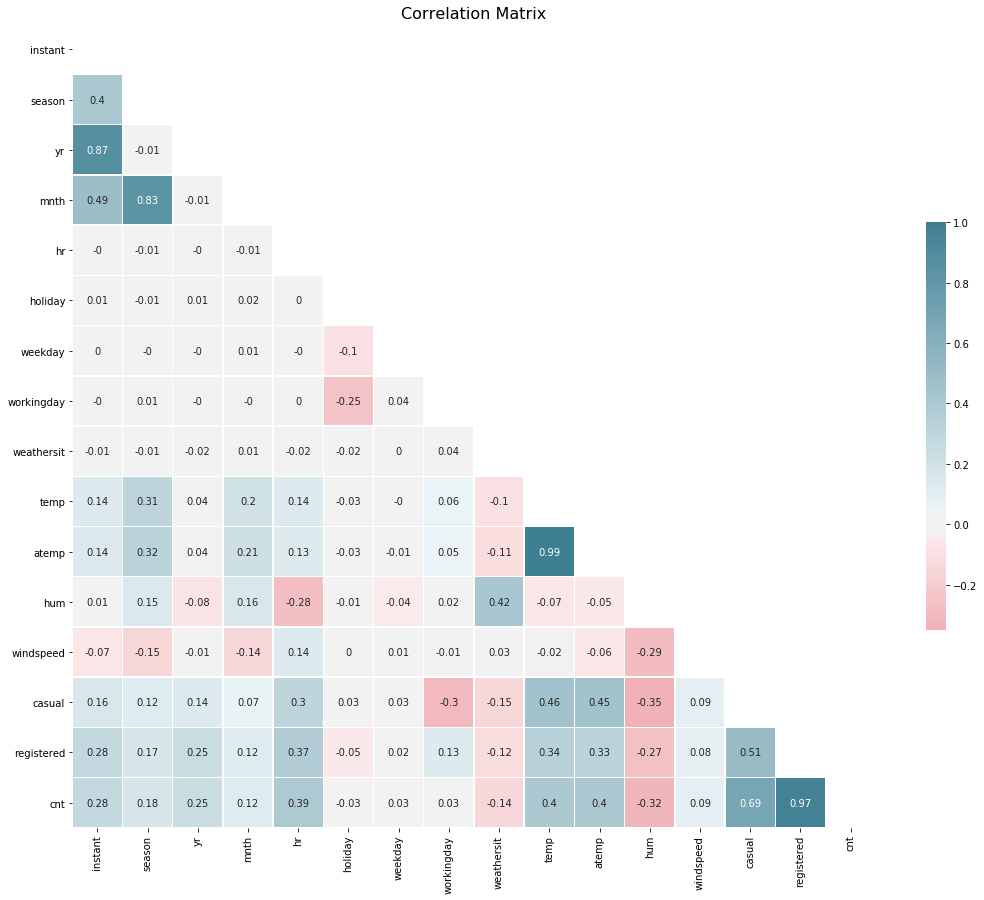

In [11]:
plot_correlation_heatmap(df)

# Show the plot
plt.show()

#### Feature Selection

What we won't use as features:
- instant (ID column - not descriptive)
- year (not reproducible)
- mnth (interchangeable with season)
- atemp (interchangeable with temp)
- registered (leak from the future)
- casual (leak from the future)

What we will use as features:
- season
- hr
- holiday
- weekday
- workingday
- weathersit
- temp
- hum
- windspeed

Target variable:
- cnt

#### A note about our target possibilities:
- we can create two models on casual and registered instead of one on cnt

Test wether casual + registered equals cnt or not.

In [12]:
test = train_df['casual'] + train_df['registered'] == train_df['cnt']
assert test.sum() == len(test)

It does.

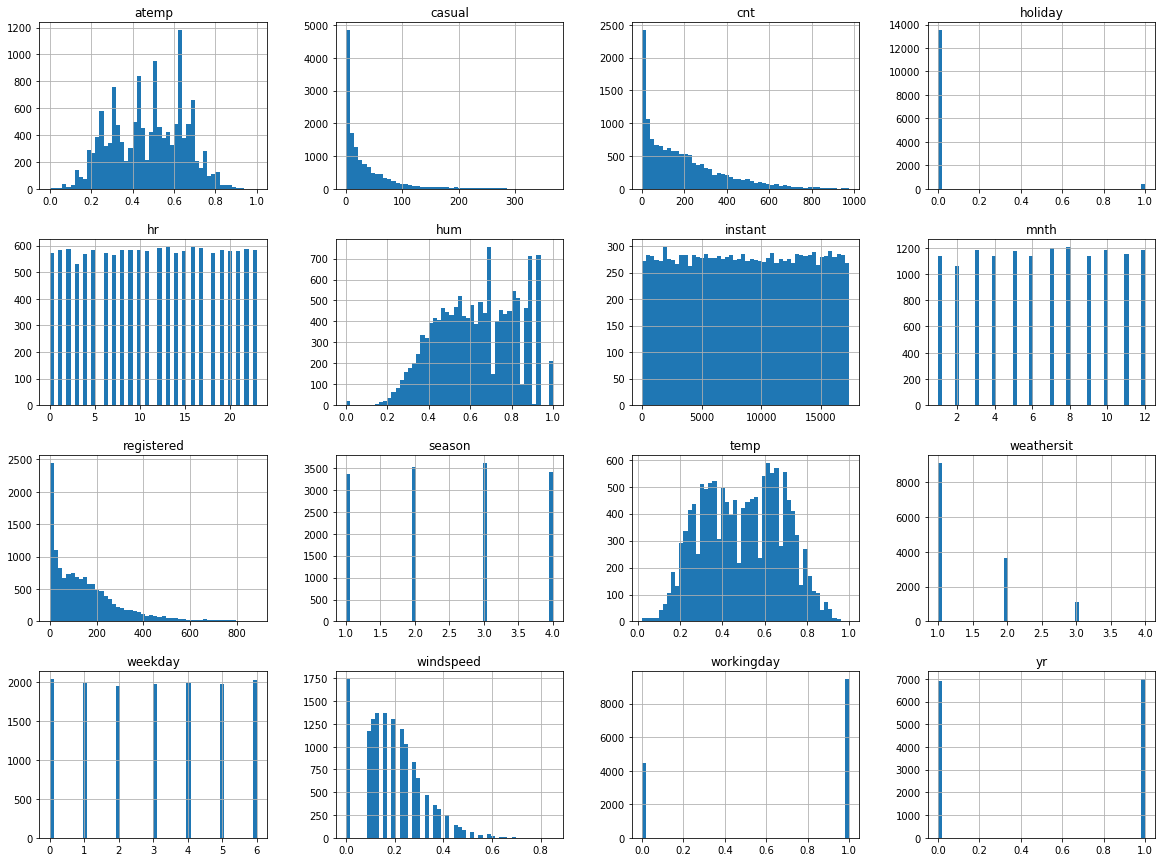

In [13]:
train_df.hist(bins=50, figsize=(20,15))
plt.show()

In [14]:
features = ['season', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'hum', 'windspeed']
targets = ['casual', 'registered', 'cnt']

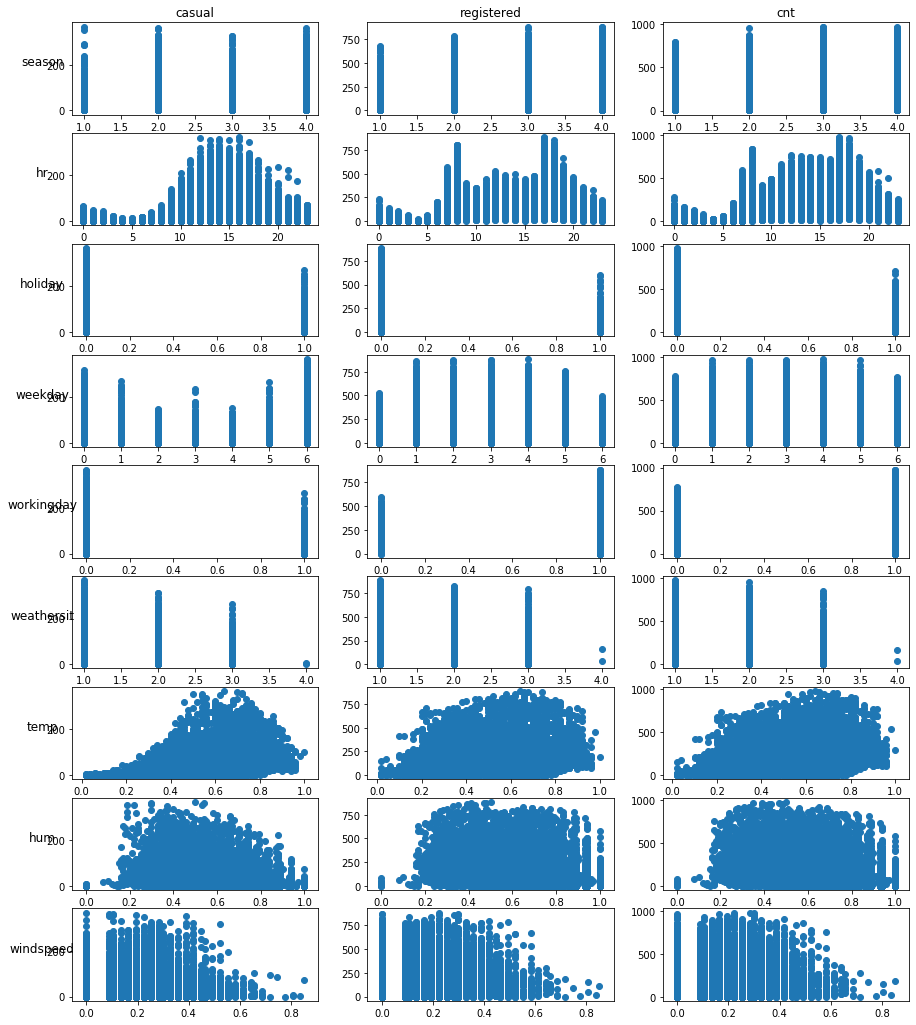

In [15]:
figure, axes = plt.subplots(figsize=(15, 18), nrows=len(features), ncols=len(targets))

for feat_num, feature in enumerate(features):
    for target_num, target in enumerate(targets):
        axes[feat_num, target_num].scatter(train_df[feature], train_df[target])
        
for ax, target in zip(axes[0], targets):
    ax.set_title(target)

for ax, feature in zip(axes[:,0], features):
    ax.set_ylabel(feature, rotation=0, size='large')

plt.show()

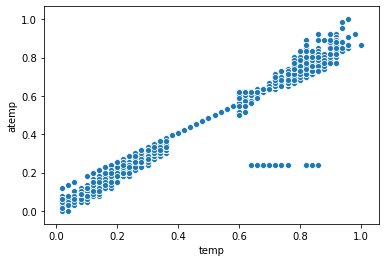

In [16]:
ax = sns.scatterplot(x="temp", y="atemp", data=train_df)

It seems we have some anomalous values - values where atemp seems to have a value of about 0.22 but temp has values between 0.6 and 0.9. We should remove these observations.

In [17]:
temp_mask = (train_df['temp'] > 0.6) & (train_df['temp'] < 0.9)
atemp_mask = (train_df['atemp'] > 0.15) & (train_df['atemp'] < 0.3)
anomalous_df = train_df[temp_mask & atemp_mask]
anomalous_df

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
14143,14144,2012-08-17,3,1,8,12,0,5,1,1,0.82,0.2424,0.41,0.2239,110,255,365
14134,14135,2012-08-17,3,1,8,3,0,5,1,1,0.64,0.2424,0.65,0.1045,0,6,6
14141,14142,2012-08-17,3,1,8,10,0,5,1,1,0.74,0.2424,0.55,0.1642,82,149,231
14147,14148,2012-08-17,3,1,8,16,0,5,1,2,0.84,0.2424,0.32,0.4478,116,372,488
14152,14153,2012-08-17,3,1,8,21,0,5,1,2,0.68,0.2424,0.69,0.2985,57,198,255
14131,14132,2012-08-17,3,1,8,0,0,5,1,1,0.68,0.2424,0.57,0.1642,21,67,88
14138,14139,2012-08-17,3,1,8,7,0,5,1,1,0.64,0.2424,0.73,0.1045,11,368,379
14142,14143,2012-08-17,3,1,8,11,0,5,1,1,0.76,0.2424,0.52,0.2836,98,205,303
14132,14133,2012-08-17,3,1,8,1,0,5,1,1,0.66,0.2424,0.65,0.1045,16,38,54
14151,14152,2012-08-17,3,1,8,20,0,5,1,2,0.72,0.2424,0.58,0.2239,97,262,359


So it seems there is an error with atemp, which has for a few values of temp a fixed value of 0.2424.
We can therefore remove atemp and use temp, to avoid these errors. This would have minimal to no impact, given temp and atemp are highly correlated (0.99).

#### Data Cleaning

- weekday (transform into boolean)
- weathersit (one hot encoding)

In [18]:
# create is_weekend = 1 if weekday is Saturday (6) or Sunday (0)
train_df['is_weekend'] = train_df['weekday'].isin([0,6]).astype(int)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [19]:
train_df['weathersit'] = train_df['weathersit'].astype(str)
# Get one hot encoding of columns B
one_hot = pd.get_dummies(train_df[['weathersit']])
# Join the encoded df
train_df = train_df.join(one_hot)
# Drop column as it is now encoded and drop last dummy variable to avoid multicollinearity
train_df = train_df.drop(['weathersit', 'weathersit_4'], axis = 1)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [20]:
features = ['season', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit_1', 'weathersit_2', 'weathersit_3', 'temp', 'hum', 'windspeed']
target = ['cnt']

Next steps:

* Fortunately for us, this data has been cleaned beforehand. But, if we want to deploy these models into production, we need to connect them to the real-time data source(s), and create pipelines that clean and transform the data to match the format we used to create these models.

* One other big concern is having enough bikes in the right docking stations at the right times. The data at hand won't help us predict this, but it's a great task to pursue given that mobility data is available on [Capital Bikeshare's website](https://s3.amazonaws.com/capitalbikeshare-data/index.html). Unfortunately there's no financial data on how costly it is to frequently move bikes to the right docking stations, but that can be estimated.

#### Training and Evaluating on the Training Set

In [21]:
from sklearn.linear_model import LinearRegression

In [22]:
lr = LinearRegression()
lr.fit(train_df[features], train_df[target])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [23]:
# create is_weekend = 1 if weekday is Saturday (6) or Sunday (0)
test_df['is_weekend'] = test_df['weekday'].isin([0,6]).astype(int)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [24]:
test_df['weathersit'] = test_df['weathersit'].astype(str)
# Get one hot encoding of columns B
one_hot = pd.get_dummies(test_df[['weathersit']])
# Join the encoded df
test_df = test_df.join(one_hot)
# Drop column as it is now encoded and drop last dummy variable to avoid multicollinearity
test_df = test_df.drop(['weathersit', 'weathersit_4'], axis = 1)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [25]:
from sklearn.metrics import mean_squared_error

In [26]:
lr_predictions = lr.predict(test_df[features])
lr_mse = mean_squared_error(test_df[target], lr_predictions)
lr_rmse = np.sqrt(lr_mse)
lr_rmse

143.77129488632536

We are on average 144 bike rentals off - not great, as it is almost one standard deviation from the mean. This quite a lot, so let's find a way to improve this model.

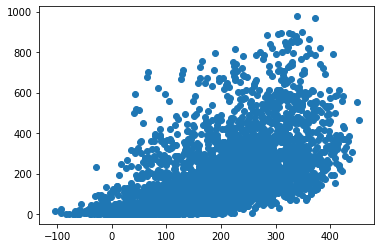

In [27]:
plt.scatter(lr_predictions, test_df['cnt'])
plt.show()

This cloud should look a lot more like a straight diagonal line, with no values below zero.
So we need to find a way to make better predictions. Linear regression will not cut it, but now we have a base.
Let's try a decision tree.

In [28]:
train_df['cnt'].sort_values()

9221       1
435        1
9557       1
1386       1
1341       1
        ... 
10622    957
15780    963
15084    967
14725    968
14964    976
Name: cnt, Length: 13903, dtype: int64

In [29]:
from sklearn.tree import DecisionTreeRegressor

dtr = DecisionTreeRegressor(random_state=42)
dtr.fit(train_df[features], train_df[target])

dtr_predictions = dtr.predict(test_df[features])
dtr_mse = mean_squared_error(test_df[target], dtr_predictions)
dtr_rmse = np.sqrt(dtr_mse)
dtr_rmse

96.65265818831712

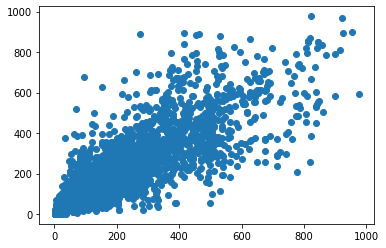

In [30]:
plt.scatter(dtr_predictions, test_df['cnt'])
plt.show()

The decision tree regression faired considerably better, cutting a third of the error. It also didn't predict any negative values (as seen in the graph) which is encouraging. What still seems to not work is the fact that the values are still highly dispersed, especially on the upper half of the values.  
Let's now go ahead and try an ensemble method, specifically a Random Forest Regressor.

In [31]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(random_state=42)
rfr.fit(train_df[features], train_df[target])

rfr_predictions = rfr.predict(test_df[features])
rfr_mse = mean_squared_error(test_df[target], rfr_predictions)
rfr_rmse = np.sqrt(rfr_mse)
rfr_rmse

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


67.32423333512419

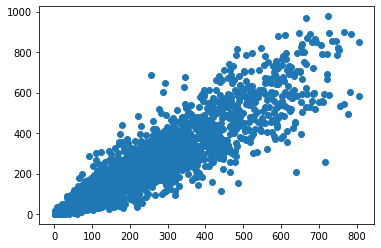

In [32]:
plt.scatter(rfr_predictions, test_df['cnt'])
plt.show()

As we can see, there is quite an improvement still, reducing the error by about 53% versus our linear regression. The dispersion shown in the decision tree is also reduced. We can try to further improve the model with a bagging method, or gradient boosting.  
Let's try both of them out. 

In [33]:
from sklearn.ensemble import BaggingRegressor

br = BaggingRegressor(random_state=42)
br.fit(train_df[features], train_df[target])

br_predictions = br.predict(test_df[features])
br_mse = mean_squared_error(test_df[target], br_predictions)
br_rmse = np.sqrt(br_mse)
br_rmse

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:399: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)


70.986552923052

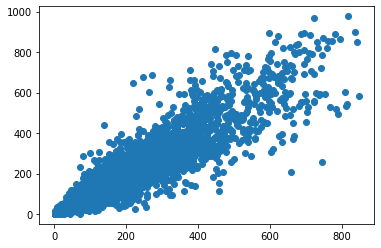

In [34]:
plt.scatter(br_predictions, test_df['cnt'])
plt.show()

In [35]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(random_state=42)
gbr.fit(train_df[features], train_df[target])

gbr_predictions = gbr.predict(test_df[features])
gbr_mse = mean_squared_error(test_df[target], gbr_predictions)
gbr_rmse = np.sqrt(gbr_mse)
gbr_rmse

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


81.13752493592833

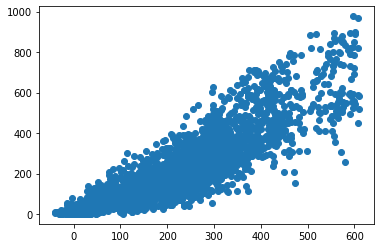

In [36]:
plt.scatter(gbr_predictions, test_df['cnt'])
plt.show()

This is interesting, it seems neither sampling with replacement (bagging) nor improving on preceding models (gradient boosting) helped reduce prediction error. Up until now our best option is indeed the Random Forrest. Let's try one last thing before we move onto other ways to improve the accuracy: SVMs.

In [37]:
from sklearn.svm import SVR

svr = SVR()
svr.fit(train_df[features], train_df[target])

svr_predictions = svr.predict(test_df[features])
svr_mse = mean_squared_error(test_df[target], svr_predictions)
svr_rmse = np.sqrt(svr_mse)
svr_rmse

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


145.5063406050372

Wow, so the SVM performed even worse than our baseline model. Quite a surprise.  
Let's check out the scatterplot to see if the algorithm is making any systematic errors, or if it's just bad at predicting on this problem.

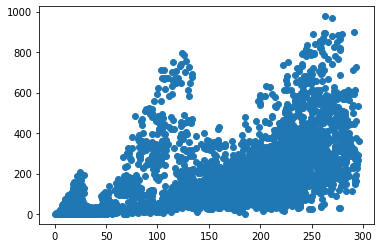

In [38]:
plt.scatter(svr_predictions, test_df['cnt'])
plt.show()

Indeed the SVM is all over the place. It looks like it's modelling the noise more than the signal.
We have a clear winner: Random Forest!
Now let's try to improve that further.

### Splitting the targets

We've seen above that there are some differences between the casual and registered counts and their relationships with the feature variables.
It would make sense to try and see if we build two different models, one to predict each number, it would improve the overall prediction. Our target now is to get a better result that the Random Forrest regressor.

In [39]:
casual_target = 'casual'

rfr_casual = RandomForestRegressor(random_state=42)
rfr_casual.fit(train_df[features], train_df[casual_target])

rfr_casual_predictions = rfr_casual.predict(test_df[features])

In [40]:
rfr_casual_fi = pd.Series(rfr_casual.feature_importances_, index = features)
rfr_casual_fi.sort_values(ascending=False)

hr              0.383024
temp            0.242506
workingday      0.197178
hum             0.084789
windspeed       0.036135
weekday         0.021839
season          0.019400
weathersit_1    0.004408
holiday         0.004177
weathersit_2    0.003328
weathersit_3    0.003217
dtype: float64

In [41]:
registered_target = 'registered'

rfr_registered = RandomForestRegressor(random_state=42)
rfr_registered.fit(train_df[features], train_df[registered_target])

rfr_registered_predictions = rfr_registered.predict(test_df[features])

In [42]:
rfr_registered_fi = pd.Series(rfr_registered.feature_importances_, index = features)
rfr_registered_fi.sort_values(ascending=False)

hr              0.574148
workingday      0.118945
temp            0.116984
hum             0.063529
season          0.038717
windspeed       0.035715
weekday         0.024058
weathersit_3    0.016742
weathersit_1    0.004855
weathersit_2    0.003522
holiday         0.002785
dtype: float64

In [43]:
total_predictions = rfr_casual_predictions + rfr_registered_predictions

rfr_total_mse = mean_squared_error(test_df[target], total_predictions)
rfr_total_rmse = np.sqrt(rfr_total_mse)
rfr_total_rmse

66.46372782478929

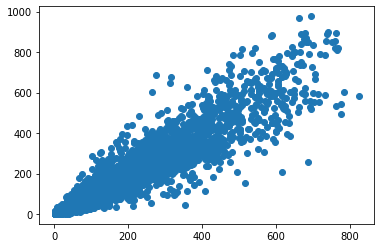

In [44]:
plt.scatter(total_predictions, test_df['cnt'])
plt.show()

In [45]:
from sklearn.metrics import mean_squared_log_error

msle = mean_squared_log_error(test_df[target], total_predictions)
msle

0.1665647317070231

What else can we try?
- PCA

In [46]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

x = train_df.loc[:, features].values# Separating out the target
y = train_df.loc[:, target].values# Standardizing the features
x = StandardScaler().fit_transform(x)

In [47]:
pca = PCA(n_components=10)
pca.fit(x)
print(pca.explained_variance_ratio_)

[0.1977126  0.12996811 0.11936633 0.1137882  0.1074819  0.08872075
 0.07402669 0.06750261 0.05843414 0.04297226]


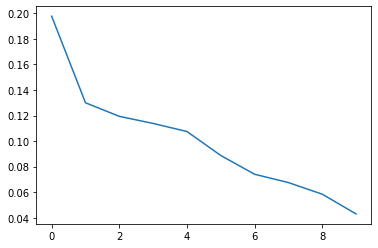

In [48]:
plt.plot(pca.explained_variance_ratio_)